In [39]:
from ResComp import *
from specializeGraph import *
from specializer import *
from matplotlib import pyplot as plt
import networkx as nx
import copy
import random
import sys

plt.rcParams['figure.figsize'] = [10, 5]


BEGIN      = 0
END        = 60
TIMESTEPS  = 60000
X0         = [-20, 10, -.5]
FNAME      = "/Users/djpassey/Code/work/NetworkResearch/UVMproject/data/specRandNets/specNetw{}.csv"
NUM_SPECI  = 1042


In [112]:
def lorentz_deriv(t0, X, sigma=10., beta=8./3, rho=28.0):
    """Compute the time-derivative of a Lorenz system."""
    (x, y, z) = X
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]
# end

def lorenz_equ(x0=X0, begin=BEGIN, end=END, timesteps=TIMESTEPS):
    """Use solve_ivp to produce a solution to the lorenz equations""" 
    t = np.linspace(begin,end,timesteps)
    train_t = t[:len(t)//2]
    u = integrate.solve_ivp(lorentz_deriv, (begin,end),x0, dense_output=True).sol
    return t, train_t, u
# end

def toterror(u,pre):
    """Sum of ||u_i - pre_i||_2 for all i"""
    return np.sum(np.sum((u - pre)**2, axis=0)**.5)
# end

def msqerror(u,pre):
    """Mean squared error"""
    return np.mean(np.sum((u - pre)**2, axis=0)**.5)
# end

def maxdist(u,pre):
    """ Max over i of ||u_i - pre_i||"""
    return np.max(np.sum((u - pre)**2, axis=0)**.5)
# end

def load_spec(i):
    return np.genfromtxt(FNAME.format(i), delimiter=",")
# end

def config_model(A):
    """Produce a network with the same degree distribution as the 
        network with adj matrix A"""

    # Get in and out deg distributions
    G    = nx.DiGraph(A)
    din  = sorted([ d for n,d in G.in_degree()], reverse=True)
    dout = sorted([d for n,d in G.out_degree()], reverse=True)
    
    # Create new adj matrix
    M    = nx.directed_configuration_model(din,dout, create_using=nx.DiGraph)
    M    = nx.DiGraph(M) # Removes parellel edges
    M    = nx.adj_matrix(M).toarray()
    
    return M
# end

def score_nodes(rc, u, t, r_0=None):
    """ Give every node in the reservoir a relative importance score
        
        Parameters
        ----------
        rc (ResComp): reservoir computer
        u  (solve_ivp solution): system to model
        t  (ndarray): time values to test 
        
        Returns
        -------
        scores (ndarray): Each node's importance score
    """
    pre, r     = rc.predict(t, return_states=True, r_0=r_0)
    derivative = rc.W_out.T.dot(pre - u(t))
    scores     = np.mean(np.abs(derivative*r), axis=1)
    return scores
# end

def specialize_best_nodes(rc, how_many, u, t, r_0=None): 
    """ Specializes the most useful nodes in the reservoir and
        returns an adjacency matrix of the specialized reservoir
        
        Parameters
        ----------
        rc (ResComp): reservoir computer
        how_many (int): How many nodes to specialize
        u  (solve_ivp solution): system to model
        t  (ndarray): time values to test
        
        Returns
        S (ndarray): adj matrix of the specialized reservoir
        """
    scores     = score_nodes(rc, u, t, r_0=r_0)
    tot        = rc.res.shape[0]
    worst_idxs = list(np.argsort(scores)[1:(tot-how_many)])
    A          = rc.res
    for i in range(tot): A[i,i] = 0
    A          = (A != 0)*1
    S          = specializeGraph(A, worst_idxs)
    return S
# end   
    
def how_long_accurate(u, pre, tol=1):
    """ Find the first i such that ||u_i - pre_i||_2 > tol """
    for i in range(u.shape[1]):
        dist = np.sum((u[:,i] - pre[:,i])**2)**.5
        if dist > tol:
            return i        
    return u.shape[1]
# end

def make_res_comp(A, params):
    # Make res comp with desired adj matrix A
    new_params = copy.deepcopy(params)
    m,n    = A.shape    
    new_params["res_sz"] = n
    rc     = ResComp(3,3, **new_params)
    rc.res = A * new_params["spect_rad"] / max(np.linalg.eigvals(A)).real
    return rc
# end


### Full model trajectory

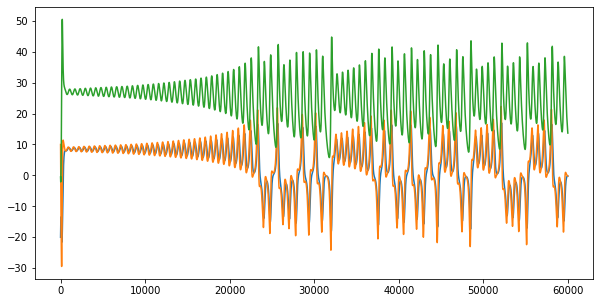

In [41]:
params = {
    "diff_eq_params" : {"x0": X0, "begin": BEGIN, "end": END, "timesteps":TIMESTEPS},
    "res_params"     : {"res_sz": 30, "activ_f": np.tanh, "connect_p": .2, "ridge_alpha": .00001, "spect_rad": .9, "gamma": 1., "sigma": 0.12, "uniform_weights": True},
    "num_trials"     : 1000,
    "mse_error"      : [],
    
}
t, train_t, u = lorenz_equ(**params["diff_eq_params"])
plt.plot(u(t).T)
plt.show()

### Truncate Trajectory for Training

We want the behavior of the Lorenz equations after the orbit reaches the attractor

In [42]:
train_t = t[30000:55000]
test_t  = t[55000:]

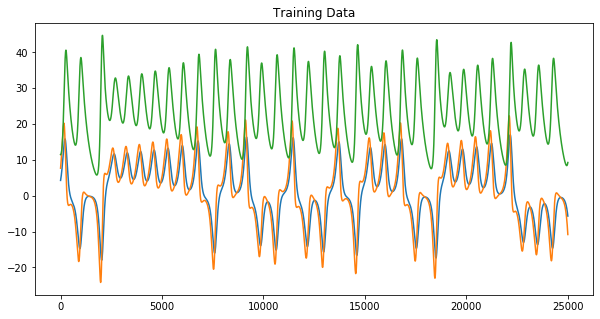

In [43]:
plt.plot(u(train_t).T)
plt.title("Training Data")
plt.show()

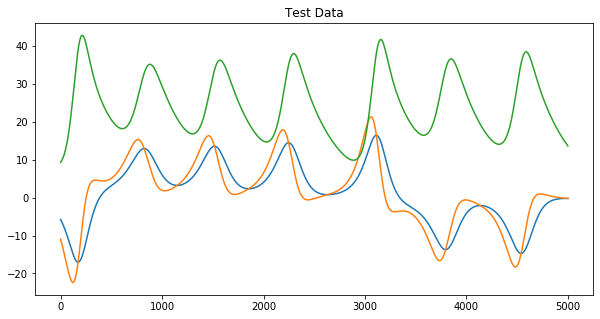

In [44]:
plt.plot(u(test_t).T)
plt.title("Test Data")
plt.show()

### Train Reservoir Computer

In [45]:
params = {
    "diff_eq_params" : {"x0": X0, "begin": BEGIN, "end": END, "timesteps":TIMESTEPS},
    "res_params"     : {"res_sz": 50, "activ_f": np.tanh, "connect_p": .02, "ridge_alpha": .00001, "spect_rad": .9, "gamma": 1., "sigma": 0.12, "uniform_weights": True},
    "num_trials"     : 100,
    "mse_error"      : [],
    
}

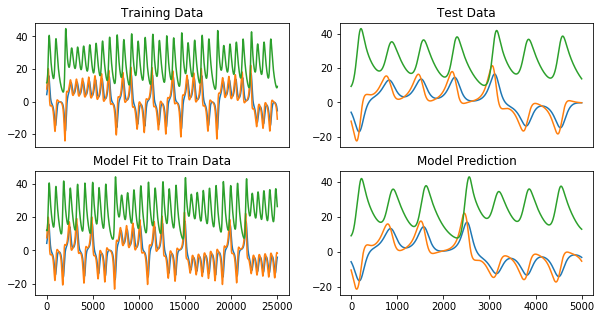

Average Error: 17.777327143621335
Accurate prediction for 1345 timesteps


In [46]:
res_params = {"res_sz": 50, 
              "activ_f": np.tanh, 
              "connect_p": .02, 
              "ridge_alpha": .00001, 
              "spect_rad": .9, 
              "gamma": 1., 
              "sigma": 0.12, 
              "uniform_weights": True},


rc = ResComp(3,3, **res_params)

r_0 = rc.state_0
rc.fit(train_t,u)
test_pre = rc.predict(test_t)
train_pre = rc.predict(train_t, r_0=r_0)

plt.subplot(221)
plt.plot(u(train_t).T)
plt.title("Training Data")
plt.xticks([])
plt.subplot(222)
plt.plot(u(test_t).T)
plt.title("Test Data")
plt.xticks([])
plt.subplot(223)
plt.plot(train_pre.T)
plt.title("Model Fit to Train Data")
plt.subplot(224)
plt.plot(test_pre.T)
plt.title("Model Prediction")
plt.show()
print("Average Error: {}".format(msqerror(u(train_t), train_pre)) )
print("Accurate prediction for {} timesteps".format(how_long_accurate(u(test_t), test_pre, tol=5)))

In [9]:
res_params = {"res_sz": 30, 
              "activ_f": np.tanh,
              "connect_p": .12, 
              "ridge_alpha": .00001, 
              "spect_rad": .9, 
              "gamma": 1., 
              "sigma": 0.12,
              "uniform_weights": True
             }
TRIALS      = 1000
NUM_TO_SPEC = 3 

random      = []
specialized = []
sizes       = []
edges       = []

for i in range(TRIALS):
    # Test random graph
    rc = ResComp(3,3,**res_params)
    r_0 = rc.state_0
    rc.fit(train_t,u)
    test_pre = rc.predict(test_t)
    train_pre = rc.predict(train_t, r_0=r_0)
    random.append(msqerror(u(train_t), train_pre))
    
    # Specialize the graph and test again
    A = specialize_best_nodes(rc, NUM_TO_SPEC, u, train_t, r_0=r_0)
    sizes.append(A.shape[0])
    edges.append(np.sum(A != 0))
    rc = make_res_comp(A, res_params)
    r_0 = rc.state_0
    rc.fit(train_t,u)
    test_pre = rc.predict(test_t)
    train_pre = rc.predict(train_t, r_0=r_0)
    specialized.append(msqerror(u(train_t), train_pre))


In [10]:
SPEC = np.copy(specialized)
RAND = np.copy(random)
SZ   = np.copy(sizes) 
ED   = np.copy(edges)

Mean Error: 15883.356448795736
Error Var: 483796157.5253241


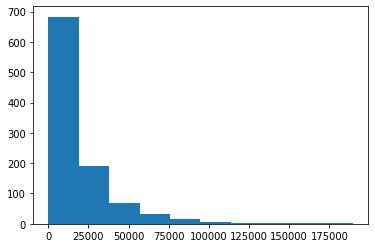

In [11]:
plt.hist(RAND)
print("Mean Error: {}".format(np.mean(RAND)))
print("Error Var: {}".format(np.var(RAND)))


Mean Error: 19.911212057306766
Error Var: 4518.077219680354


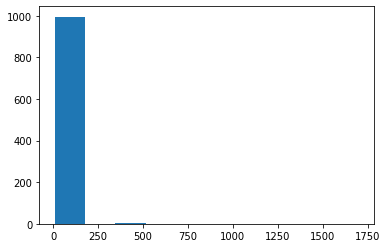

In [12]:
plt.hist(SPEC)
print("Mean Error: {}".format(np.mean(SPEC)))
print("Error Var: {}".format(np.var(SPEC)))

### Same Network Sizes

In [13]:
res_params = {"res_sz": 30, 
              "activ_f": np.tanh,
              "connect_p": .12, 
              "ridge_alpha": .00001, 
              "spect_rad": .9, 
              "gamma": 1., 
              "sigma": 0.12}
TRIALS      = 50
NUM_TO_SPEC = 3 
random_large = []

for s in SZ:
    # Test random graph
    res_params["res_sz"] = s
    rc = ResComp(3,3,**res_params)
    r_0 = rc.state_0
    rc.fit(train_t,u)
    test_pre = rc.predict(test_t)
    train_pre = rc.predict(train_t, r_0=r_0)
    random_large.append(msqerror(u(train_t), train_pre))

Mean Error: 46.287772934915296
Error Var: 20837.966716638148


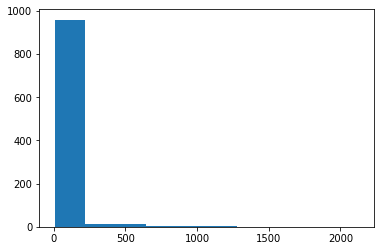

In [14]:
plt.hist(random_large)
print("Mean Error: {}".format(np.mean(random_large)))
print("Error Var: {}".format(np.var(random_large)))

### Same Sizes and Same Edge Densities

In [16]:
res_params = {"res_sz": 30, 
              "activ_f": np.tanh,
              "connect_p": .12, 
              "ridge_alpha": .00001, 
              "spect_rad": .9, 
              "gamma": 1., 
              "sigma": 0.12}

for s,e in zip(SZ,ED):
    # Test random graph
    res_params["res_sz"] = s
    res_params["connect_p"] = e/(s**2)
    rc = ResComp(3,3,**res_params)
    r_0 = rc.state_0
    rc.fit(train_t,u)
    test_pre = rc.predict(test_t)
    train_pre = rc.predict(train_t, r_0=r_0)
    match_edge.append(msqerror(u(train_t), train_pre))

Mean Error: 33.73422800679435
Error Var: 33605.78820215677


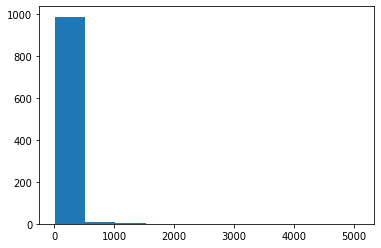

In [17]:
plt.hist(match_edge)
print("Mean Error: {}".format(np.mean(match_edge)))
print("Error Var: {}".format(np.var(match_edge)))

In [18]:
results = np.zeros((4,2))
i = 0
for data in [random, random_large, match_edge, SPEC][::-1]:
    results[i] = [np.mean(data), np.std(data)]
    i += 1
# end


In [19]:
import pandas as pd
data = {"Method"     : ["Specialized", "Same # Nodes and Edges", "Same Number of Nodes", "Original Network"],
        "Mean Error" : results[:,0],
        "Error Std"  : results[:,1]
       }
df = pd.DataFrame(data)
print(df)

                   Method    Mean Error     Error Std
0             Specialized     19.911212     67.216644
1  Same # Nodes and Edges     33.734228    183.318816
2    Same Number of Nodes     46.287773    144.353617
3        Original Network  15883.356449  21995.366729


In [43]:
np.mean(ED/SZ**2)

0.02349210596382511

### Notes:
I ran the tests on a reservoir computer with 50 nodes and when I decreased the sparsity to .02 from .1 the rc started being able to model the system.

Is there a minimal network that can capture the lorenz system's lyapunov exponents
Are the most important nodes always neighbors? Always part of the same strongly connected component? Size of the stongly connected component containing the most important nodes.

#### Question
Does specialization limit out when we pick high performers?
Is it limited to the neighborhood?

Limiting growth schemes:
Grow until  

In [61]:
rc = make_res_comp(A, res_params)
r_0 = rc.state_0
rc.fit(train_t,u)
score = score_nodes(rc, u, train_t)
G = nx.DiGraph(rc.res)

In [68]:
scc = [c for c in nx.strongly_connected_components(G)]

In [71]:
np.argsort(score)

array([139,   6,   8,  21,  24,   1, 137,  22,  59,  83,  63,  81,   5,
        48,  52,  60,  99, 113, 122,  79,  69,  23,  84, 127,  46,  88,
        68,  54,   3,  86,  38,  97, 108,  12,  36,  67,  15,  80,  77,
        44,  75,  13,  98,  11,  85, 110, 125,  34,  57,  71, 123,  50,
         7,  51,  26, 124,  47,  70, 106,   9, 121,  61,  35,  16, 126,
        53, 115, 107,  14, 105,  40,  74, 104,  49,  65,  66, 130, 134,
        76,  10,  87,  64,  19, 112,  29,  25,  95,  82,  43,  58,  32,
        90,  17,  20, 131, 101,  78,  37,   2,  62,  72,   0, 138, 132,
       116, 129,  42, 109, 117,  73,  55,  96,  92,  30,  18, 100, 114,
       111,   4, 120, 119,  28, 133,  33,  45,  91,  41, 102,  31,  56,
        39,  93,  27,  89, 103, 136,  94, 135, 118, 128])

In [84]:
np.argmax(list(map(len,scc)))

14

In [102]:


data = dict()
sort_scores = np.argsort(score)

data["Score"] = score[np.argsort(score)]
data["In Degree"] = list(map(lambda x: G.in_degree(x), sort_scores))
data["Out Degree"] = list(map(lambda x: G.out_degree(x), sort_scores))
eig_cent = nx.eigenvector_centrality(G)
data["Eigencentrality"] = list(map(lambda x: eig_cent[x],sort_scores))
                         

In [103]:
df = pd.DataFrame(data)

In [104]:
df

,Score,In Degree,Out Degree,Eigencentrality
0,40.136282,1,1,4.485828e-14
1,48.390384,3,6,4.444099e-02
2,48.970676,12,2,1.527643e-01
3,51.462148,5,8,2.138859e-01
4,55.565450,0,16,2.039013e-15
...,...,...,...,...
135,2151.385587,1,1,4.439253e-02
136,2554.431500,1,1,6.136540e-02
137,2809.839443,1,1,4.485828e-14
138,2985.250082,1,1,1.582853e-02


In [107]:
rc = ResComp(3,3, **res_params)
r_0 = rc.state_0
rc.fit(train_t,u)
score = score_nodes(rc, u, train_t)
G = nx.DiGraph(rc.res)

In [117]:
data = dict()
sort_scores = np.argsort(score)

data["Score"] = score[np.argsort(score)]
data["In Degree"] = list(map(lambda x: G.in_degree(x), sort_scores))
data["Out Degree"] = list(map(lambda x: G.out_degree(x), sort_scores))
eig_cent = nx.eigenvector_centrality(G)
data["Eigencentrality"] = list(map(lambda x: eig_cent[x],sort_scores))
data["Ingoing Sum"] = list(map(lambda x: np.sum(np.abs(rc.W_in[x,:])), sort_scores))

In [118]:
pd.DataFrame(data)

,Score,In Degree,Out Degree,Eigencentrality,Ingoing Sum
0,15.242542,2,3,2.048109e-01,0.965803
1,40.594631,2,1,1.123361e-01,0.921576
2,71.624833,2,2,9.128173e-02,0.525308
3,74.929365,1,2,9.633070e-02,1.137785
4,85.381623,4,1,4.168117e-02,0.897255
...,...,...,...,...,...
135,3570.408926,2,0,6.687489e-02,0.448874
136,3602.040804,0,1,1.046441e-22,1.253629
137,3782.906839,2,1,1.591801e-01,0.544152
138,3883.364611,0,1,1.046441e-22,0.533078


In [119]:
df.corr()

,Score,In Degree,Out Degree,Eigencentrality
Score,1.000000,-0.164331,-0.222589,-0.139196
In Degree,-0.164331,1.000000,0.314152,0.820144
Out Degree,-0.222589,0.314152,1.000000,0.466122
Eigencentrality,-0.139196,0.820144,0.466122,1.000000


### Specialization without finding best nodes

In [22]:
res_params = {"res_sz": 30, 
              "activ_f": np.tanh,
              "connect_p": .12, 
              "ridge_alpha": .00001, 
              "spect_rad": .9, 
              "gamma": 1., 
              "sigma": 0.12,
              "uniform_weights": True
             }
TRIALS      = 1000
NUM_TO_SPEC = 3 

random_g      = []
specialized   = []
sizes         = []
edges         = []

for i in range(TRIALS):
    # Test random graph
    rc = ResComp(3,3,**res_params)
    r_0 = rc.state_0
    rc.fit(train_t,u)
    test_pre = rc.predict(test_t)
    train_pre = rc.predict(train_t, r_0=r_0)
    random_g.append(msqerror(u(train_t), train_pre))
    # Specialize the graph and test again
    A          = rc.res
    for j in range(A.shape[0]): A[j,j] = 0
    A          = (A != 0)*1
    A          = specializeGraph(A, random.sample(list(range(30)),27))
    sizes.append(A.shape[0])
    edges.append(np.sum(A != 0))
    rc = make_res_comp(A, res_params)
    r_0 = rc.state_0
    rc.fit(train_t,u)
    test_pre = rc.predict(test_t)
    train_pre = rc.predict(train_t, r_0=r_0)
    specialized.append(msqerror(u(train_t), train_pre))
    sys.stdout.write("#"+(i // 50)*"#"+"\r")

Mean Error: 16132.862201474938
Error Std: 21752.942813226942


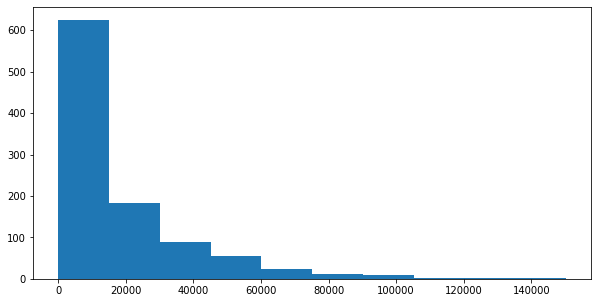

In [32]:
plt.hist(random_g)
print("Mean Error: {}".format(np.mean(random_g)))
print("Error Std: {}".format(np.std(random_g)))

Mean Error: 38.896811671516986
Error Std: 187.57757132928074


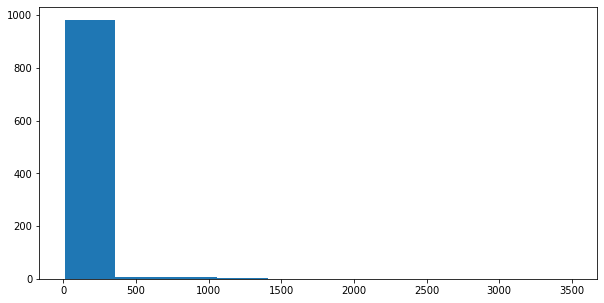

In [33]:
plt.hist(specialized)
print("Mean Error: {}".format(np.mean(specialized)))
print("Error Std: {}".format(np.std(specialized)))

In [25]:
random_large = []

for s in sizes:
    # Test random graph
    res_params["res_sz"] = s
    rc = ResComp(3,3,**res_params)
    r_0 = rc.state_0
    rc.fit(train_t,u)
    test_pre = rc.predict(test_t)
    train_pre = rc.predict(train_t, r_0=r_0)
    random_large.append(msqerror(u(train_t), train_pre))
    sys.stdout.write("#"+(i // 50)*"#"+"\r")

Mean Error: 51354.99641086582
Error Std: 71135.54415891887


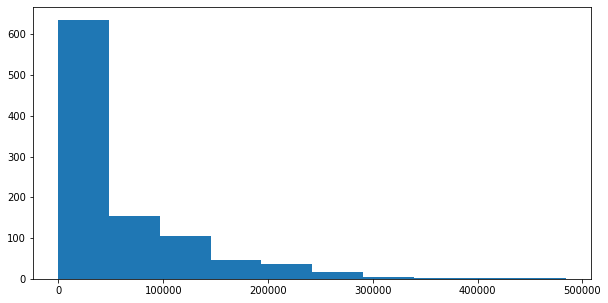

In [34]:
plt.hist(random_large)
print("Mean Error: {}".format(np.mean(random_large)))
print("Error Std: {}".format(np.std(random_large)))

In [27]:
match_edge = []

for s,e in zip(sizes, edges):
    # Test random graph
    res_params["res_sz"] = s
    res_params["connect_p"] = e/(s**2)
    rc = ResComp(3,3,**res_params)
    r_0 = rc.state_0
    rc.fit(train_t,u)
    test_pre = rc.predict(test_t)
    train_pre = rc.predict(train_t, r_0=r_0)
    match_edge.append(msqerror(u(train_t), train_pre))
    sys.stdout.write("#"+(i // 50)*"#"+"\r")

Mean Error: 825.8280518756064
Error Std: 3022.7359785044


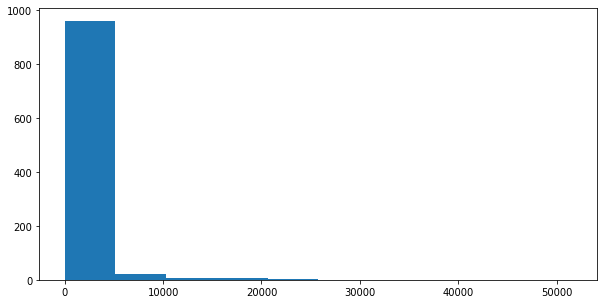

In [35]:
plt.hist(match_edge)
print("Mean Error: {}".format(np.mean(match_edge)))
print("Error Std: {}".format(np.std(match_edge)))

In [38]:
list(map(np.min, [specialized, random_g, random_large, match_edge]))

[9.149119748759777, 14.574474351085291, 12.706395861809906, 6.232689700262747]

### Improvement Plots

#### Original

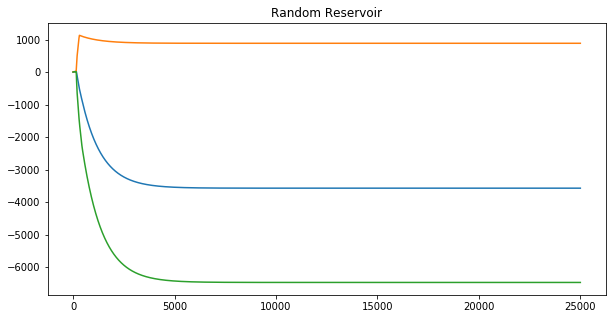

In [105]:
res_params = {"res_sz": 30, 
              "activ_f": np.tanh, 
              "connect_p": .12, 
              "ridge_alpha": .00001, 
              "spect_rad": .9, 
              "gamma": 1., 
              "sigma": 0.12, 
              "uniform_weights": True}


rc = ResComp(3,3, **res_params)

r_0 = rc.state_0
rc.fit(train_t,u)
train_pre_0 = rc.predict(train_t, r_0=r_0)

plt.plot(train_pre_0.T)
plt.title("Random Reservoir")
plt.show()

#### Random Specialization

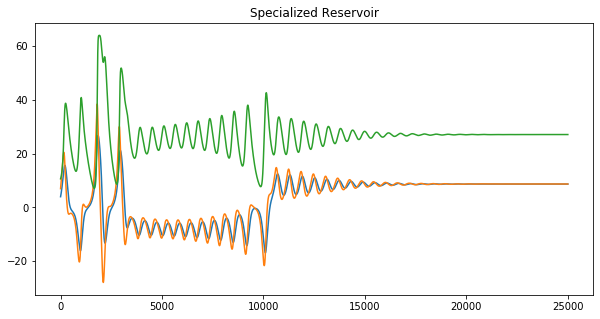

In [106]:
# Specialize the graph and test again
A          = rc.res
for j in range(A.shape[0]): A[j,j] = 0
A          = (A != 0)*1
A          = specializeGraph(A, random.sample(list(range(30)),27))

rc1 = make_res_comp(A, res_params)
r1_0 = rc1.state_0
rc1.fit(train_t,u)
train_pre_1 = rc1.predict(train_t, r_0=r1_0)
plt.plot(train_pre_1.T)
plt.title("Specialized Reservoir")
plt.show()

Text(0.5, 1.0, 'Solution')

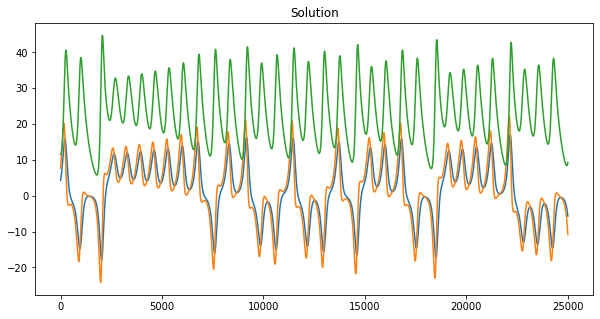

In [110]:
plt.plot(u(train_t).T)
plt.title("Solution")

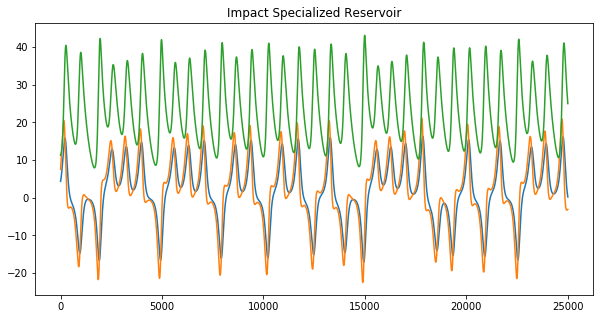

In [108]:
A = specialize_best_nodes(rc, NUM_TO_SPEC, u, train_t, r_0=r_0)

rc2 = make_res_comp(A, res_params)
r_0 = rc2.state_0
rc2.fit(train_t,u)
train_pre_2 = rc2.predict(train_t, r_0=r_0)
plt.plot(train_pre_2.T)
plt.title("Impact Specialized Reservoir")
plt.show()

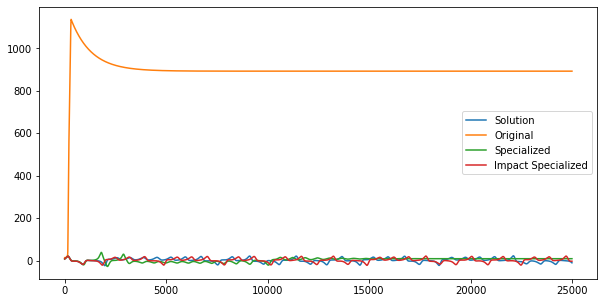

In [109]:
plt.plot(u(train_t).T[:,1], label="Solution")
plt.plot(train_pre_0.T[:,1], label="Original")
plt.plot(train_pre_1.T[:,1], label="Specialized")
plt.plot(train_pre_2.T[:,1], label="Impact Specialized")
plt.legend()